### 0. Load Dependencies

In [1]:
import numpy as np
import pickle
import time
from KNN_Shapley import get_VN, get_true_KNN, compute_KNN_shapley, compute_KNN_Asymmetric_Shapley, KNN_LOO, Logistic_LOO
from performance_plot import removing_sequential_data, adding_sequential_data, final_plot
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### 1. Load Data and Select Data Based on MC Values

In [14]:
# Load data
add_ratio = 0.15
n_samples = 10
num_permutations = 6000
m1, m2, m3, m4, m5, m6 = 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'

for i_split in range(n_samples):
    
    print('split', i_split+1)
    # Load data 
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "rb") as fp:
        mydict = pickle.load(fp)
    
    X_m1_trn = mydict['X_{}_trn'.format(m1)]
    y_m1_trn = mydict['y_{}_trn'.format(m1)]
    X_m1m2_trn = mydict['X_{}_{}_trn'.format(m1, m2)]
    y_m1m2_trn = mydict['y_{}_{}_trn'.format(m1, m2)]
    X_m3_trn = mydict['X_{}_trn'.format(m3)]
    y_m3_trn = mydict['y_{}_trn'.format(m3)]
    s_class_dic = {0: np.asarray(range(len(X_m1_trn))),
               1: np.asarray(range(len(X_m1_trn), len(X_m1m2_trn)))}
    
    # Load knn-mc-asv
    directory = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_1/'.format(i_split+1)
    with open(directory + 'tmc_asymmetric_shapley_model=knn_metric=accuracy.pkl', 'rb') as fp:
        mc_asv_knn_dict = pickle.load(fp)
    mc_asv_knn = np.mean(mc_asv_knn_dict['marginals_tmc'][:num_permutations], axis=0)
    print('mc_asv_knn.shape', mc_asv_knn_dict['marginals_tmc'].shape,
          mc_asv_knn_dict['marginals_tmc'][:num_permutations].shape)
    
    seq_asv = np.argsort(mc_asv_knn)[::-1] # rank asv from high to low
    seq_asv_class0 = np.array([i for i in seq_asv if i in s_class_dic[0]])
    seq_asv_class1 = np.array([i for i in seq_asv if i in s_class_dic[1]])
    
    add_num = int(len(s_class_dic[1])*add_ratio)
    selected_idx_asv = np.concatenate((seq_asv_class0, seq_asv_class1[:add_num]))
    X_m1m2_trn_selected, y_m1m2_trn_selected = X_m1m2_trn[selected_idx_asv], y_m1m2_trn[selected_idx_asv]
    X_m1m2m3_trn_selected = np.concatenate((X_m1m2_trn_selected, X_m3_trn))
    y_m1m2m3_trn_selected = np.concatenate((y_m1m2_trn_selected, y_m3_trn))

    s_class_dic2 = {0: np.asarray(range(len(X_m1m2_trn_selected))),
                    1: np.asarray(range(len(X_m1m2_trn_selected), len(X_m1m2m3_trn_selected)))}

    mydict['X_m1m2_trn_knn_selected'] = X_m1m2_trn_selected
    mydict['y_m1m2_trn_knn_selected'] = y_m1m2_trn_selected
    mydict['X_m1m2m3_knn_selected'] = X_m1m2m3_trn_selected
    mydict['y_m1m2m3_knn_selected'] = y_m1m2m3_trn_selected
    
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "wb") as fp:
        pickle.dump(mydict, fp)

split 1
mc_asv_knn.shape (5000, 978) (5000, 978)
split 2
mc_asv_knn.shape (5000, 978) (5000, 978)
split 3
mc_asv_knn.shape (5000, 978) (5000, 978)
split 4
mc_asv_knn.shape (5000, 978) (5000, 978)
split 5
mc_asv_knn.shape (5000, 978) (5000, 978)
split 6
mc_asv_knn.shape (5000, 978) (5000, 978)
split 7
mc_asv_knn.shape (5000, 978) (5000, 978)
split 8
mc_asv_knn.shape (5000, 978) (5000, 978)
split 9
mc_asv_knn.shape (5000, 978) (5000, 978)
split 10
mc_asv_knn.shape (5000, 978) (5000, 978)


In [15]:
X_m3_trn.shape[0]

334

In [16]:
X_m1_trn.shape, X_m1m2_trn_selected.shape

((523, 27), (591, 27))

### 2. Sanity check: compute KNN-SV and KNN-ASV for experiment 2

In [17]:
m1, m2, m3, m4, m5, m6 = 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'
K = 5

In [18]:
for i_split in range(n_samples):
    
    print('split', i_split+1)
    
    # Load data
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "rb") as fp:
        mydict = pickle.load(fp)
    
    X_m1m2_trn_selected = mydict['X_m1m2_trn_knn_selected']  
    y_m1m2_trn_selected = mydict['y_m1m2_trn_knn_selected'] 
    X_m1m2m3_trn_selected = mydict['X_m1m2m3_knn_selected']
    y_m1m2m3_trn_selected = mydict['y_m1m2m3_knn_selected']
    X_m1m2m3_val = mydict['X_{}_{}_{}_val'.format(m1, m2, m3)]
    y_m1m2m3_val = mydict['y_{}_{}_{}_val'.format(m1, m2, m3)]
    
    s_class_dic2 = {0: np.asarray(range(len(X_m1m2_trn_selected))),
                    1: np.asarray(range(len(X_m1m2_trn_selected), len(X_m1m2m3_trn_selected)))}

    directory2 = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_split+1)
    
    # Train knn classifier
    x_m1m2m3_knn_gt = get_true_KNN(X_m1m2m3_trn_selected, X_m1m2m3_val)  
    
    # Compute KNN shapley
    start = time.time()
    knn_shaps = compute_KNN_shapley(y_m1m2m3_trn_selected, x_m1m2m3_knn_gt, y_m1m2m3_val, K)
    end = time.time()
    print("Time to compute the exact symmetric shapley values for all data:", end - start)
    np.save(directory2 + 'm1m2m3_sv_knn-asv-selected_experiment2_K={}'.format(K), knn_shaps)
    
    # Compute KNN asymmetric shapley
    start = time.time()
    knn_asym_shaps = compute_KNN_Asymmetric_Shapley(y_m1m2m3_trn_selected, x_m1m2m3_knn_gt, 
                                                    y_m1m2m3_val, K, s_class_dic2)
    end = time.time()
    print("Time to compute the exact asymmetric shapley values for all data:", end - start)
    np.save(directory2 + 'm1m2m3_asv_knn-asv-selected_experiment2_K={}'.format(K), knn_asym_shaps)
    
    # Compute the KNN LOO values
    start = time.time()
    knn_loos = KNN_LOO(X_m1m2m3_trn_selected, y_m1m2m3_trn_selected, X_m1m2m3_val, 
                       y_m1m2m3_val, K, False)
    np.save(directory2 + 'm1m2m3_loo_knn-asv-selected_experiment2_K={}'.format(K), knn_loos)

split 1


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 610.36it/s]


Time to compute the exact symmetric shapley values for all data: 0.9252328872680664


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 89.87it/s]


Time to compute the exact asymmetric shapley values for all data: 8.90017294883728
split 2


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 637.74it/s]


Time to compute the exact symmetric shapley values for all data: 0.885491132736206


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 89.94it/s]


Time to compute the exact asymmetric shapley values for all data: 8.70128583908081
split 3


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 639.51it/s]


Time to compute the exact symmetric shapley values for all data: 0.8830668926239014


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 91.53it/s]


Time to compute the exact asymmetric shapley values for all data: 8.606000900268555
split 4


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 644.87it/s]


Time to compute the exact symmetric shapley values for all data: 0.875669002532959


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 92.51it/s]


Time to compute the exact asymmetric shapley values for all data: 8.561233758926392
split 5


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 644.74it/s]


Time to compute the exact symmetric shapley values for all data: 0.8762948513031006


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 91.58it/s]


Time to compute the exact asymmetric shapley values for all data: 8.60402774810791
split 6


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 634.38it/s]


Time to compute the exact symmetric shapley values for all data: 0.8903508186340332


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 91.35it/s]


Time to compute the exact asymmetric shapley values for all data: 8.652752161026001
split 7


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 641.61it/s]


Time to compute the exact symmetric shapley values for all data: 0.88028883934021


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 91.75it/s]


Time to compute the exact asymmetric shapley values for all data: 8.607393980026245
split 8


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 644.97it/s]


Time to compute the exact symmetric shapley values for all data: 0.8755440711975098


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 89.24it/s]


Time to compute the exact asymmetric shapley values for all data: 8.766939163208008
split 9


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 644.46it/s]


Time to compute the exact symmetric shapley values for all data: 0.8763141632080078


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 89.63it/s]


Time to compute the exact asymmetric shapley values for all data: 8.724884986877441
split 10


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 622.93it/s]


Time to compute the exact symmetric shapley values for all data: 0.9065701961517334


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 89.50it/s]


Time to compute the exact asymmetric shapley values for all data: 8.77012300491333


### 3. Sanity check: check efficiency axiom for KNN-ASV values

In [19]:
for i_split in range(n_samples):
    
    print('split', i_split+1)
    
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "rb") as fp:
        mydict = pickle.load(fp)
    
    X_m1m2_trn_selected = mydict['X_m1m2_trn_knn_selected']  
    y_m1m2_trn_selected = mydict['y_m1m2_trn_knn_selected'] 
    X_m1m2m3_trn_selected = mydict['X_m1m2m3_knn_selected']
    y_m1m2m3_trn_selected = mydict['y_m1m2m3_knn_selected']
    X_m1m2m3_val = mydict['X_{}_{}_{}_val'.format(m1, m2, m3)]
    y_m1m2m3_val = mydict['y_{}_{}_{}_val'.format(m1, m2, m3)]
    
    directory2 = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_split+1)
    
    # Sanity check: verify the efficiency axiom
    m1m2m3_sv = np.load(directory2 + 'm1m2m3_sv_knn-asv-selected_experiment2_K={}.npy'.format(K))
    m1m2m3_asv = np.load(directory2 + 'm1m2m3_asv_knn-asv-selected_experiment2_K={}.npy'.format(K))
    
    m1m2_asv = m1m2m3_asv[s_class_dic2[0]]
    m3_asv = m1m2m3_asv[s_class_dic2[1]]

    vn_m1m2m3 = get_VN(X_m1m2m3_trn_selected, X_m1m2m3_val, y_m1m2m3_trn_selected, y_m1m2m3_val, K)
    print(' ')
    print('V(N) of previous and current month data points:', vn_m1m2m3)
    print('sum of shapley value of previous and current month data points:', m1m2m3_sv.sum())

    vn_m1m2 = get_VN(X_m1m2_trn_selected, X_m1m2m3_val, y_m1m2_trn_selected, y_m1m2m3_val, K)
    print(' ')
    print('V(N) of previous month data points:', vn_m1m2)
    print('sum of asymmetric shapley value of previous month data points:', m1m2_asv.sum())

    vn_m3 = vn_m1m2m3 - vn_m1m2
    print(' ')
    print('V(N) of current month data points:', vn_m3)
    print('sum of asymmetric shapley value of current month data points:', m3_asv.sum())
    print(' ')
    print(' ')

split 1


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 728.34it/s]


 
V(N) of previous and current month data points: 0.8411347517730512
sum of shapley value of previous and current month data points: 0.8411347517730494


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1161.01it/s]


 
V(N) of previous month data points: 0.8134751773049659
sum of asymmetric shapley value of previous month data points: 0.8134751773049645
 
V(N) of current month data points: 0.027659574468085313
sum of asymmetric shapley value of current month data points: 0.027659574468086513
 
 
split 2


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 735.90it/s]


 
V(N) of previous and current month data points: 0.8382978723404269
sum of shapley value of previous and current month data points: 0.8382978723404254


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1157.13it/s]


 
V(N) of previous month data points: 0.8095744680851076
sum of asymmetric shapley value of previous month data points: 0.8095744680851064
 
V(N) of current month data points: 0.028723404255319274
sum of asymmetric shapley value of current month data points: 0.028723404255319322
 
 
split 3


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 728.60it/s]


 
V(N) of previous and current month data points: 0.8304964539007104
sum of shapley value of previous and current month data points: 0.8304964539007091


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1152.25it/s]


 
V(N) of previous month data points: 0.813829787234044
sum of asymmetric shapley value of previous month data points: 0.8134751773049644
 
V(N) of current month data points: 0.016666666666666385
sum of asymmetric shapley value of current month data points: 0.017021276595750055
 
 
split 4


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 731.46it/s]


 
V(N) of previous and current month data points: 0.8397163120567399
sum of shapley value of previous and current month data points: 0.8397163120567376


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1142.28it/s]


 
V(N) of previous month data points: 0.813829787234044
sum of asymmetric shapley value of previous month data points: 0.8138297872340424
 
V(N) of current month data points: 0.025886524822695933
sum of asymmetric shapley value of current month data points: 0.025886524822689848
 
 
split 5


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 730.93it/s]


 
V(N) of previous and current month data points: 0.8304964539007101
sum of shapley value of previous and current month data points: 0.8304964539007091


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1159.56it/s]


 
V(N) of previous month data points: 0.8053191489361712
sum of asymmetric shapley value of previous month data points: 0.8053191489361703
 
V(N) of current month data points: 0.02517730496453896
sum of asymmetric shapley value of current month data points: 0.025177304964541656
 
 
split 6


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 723.20it/s]


 
V(N) of previous and current month data points: 0.8397163120567399
sum of shapley value of previous and current month data points: 0.8397163120567375


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1146.57it/s]


 
V(N) of previous month data points: 0.8134751773049661
sum of asymmetric shapley value of previous month data points: 0.8134751773049644
 
V(N) of current month data points: 0.02624113475177381
sum of asymmetric shapley value of current month data points: 0.02624113475177408
 
 
split 7


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 728.85it/s]


 
V(N) of previous and current month data points: 0.8273049645390085
sum of shapley value of previous and current month data points: 0.827304964539007


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1151.09it/s]


 
V(N) of previous month data points: 0.8035460992907817
sum of asymmetric shapley value of previous month data points: 0.8035460992907801
 
V(N) of current month data points: 0.02375886524822679
sum of asymmetric shapley value of current month data points: 0.023758865248225798
 
 
split 8


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 731.71it/s]


 
V(N) of previous and current month data points: 0.8234042553191506
sum of shapley value of previous and current month data points: 0.8234042553191488


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1152.67it/s]


 
V(N) of previous month data points: 0.7975177304964555
sum of asymmetric shapley value of previous month data points: 0.7975177304964538
 
V(N) of current month data points: 0.025886524822695156
sum of asymmetric shapley value of current month data points: 0.025886524822693022
 
 
split 9


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 738.27it/s]


 
V(N) of previous and current month data points: 0.8241134751773068
sum of shapley value of previous and current month data points: 0.8241134751773049


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1155.61it/s]


 
V(N) of previous month data points: 0.8021276595744694
sum of asymmetric shapley value of previous month data points: 0.802127659574468
 
V(N) of current month data points: 0.02198581560283741
sum of asymmetric shapley value of current month data points: 0.02198581560283627
 
 
split 10


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 738.68it/s]


 
V(N) of previous and current month data points: 0.835460992907803
sum of shapley value of previous and current month data points: 0.8354609929078014


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1157.82it/s]

 
V(N) of previous month data points: 0.8223404255319162
sum of asymmetric shapley value of previous month data points: 0.8223404255319148
 
V(N) of current month data points: 0.013120567375886738
sum of asymmetric shapley value of current month data points: 0.013120567375887536
 
 


### 4. Performance Plot: KNN model

In [22]:
def removing_sequential_data(shap_vals_lst, shap_vals_algo_lst, X_ori_aug, y_ori_aug, X_test, y_test,
                             num_trn_ori, ind_arr, directory, model, metrics, plot_every_percentage, 
                             low_value_first=True):

    frac_data_removed = []
    sort_val_idxs_lst = []
    ind_arr_lst = []

    num_trn = len(X_ori_aug)
    num_trn_aug = num_trn - num_trn_ori

    for j in range(len(shap_vals_lst)):
        if low_value_first:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[j]))
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[j])])
        else:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[j])[::-1])
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[j])[::-1]])

    acc_score_lst = [[] for _ in range(len(shap_vals_lst))]
    
    for i in range(0, num_trn_aug, round(num_trn_aug * plot_every_percentage)):
        frac_data_removed.append(round(i / num_trn_aug, 2) * 100)
        for j in range(len(shap_vals_lst)):
            selected_idxs_j = np.concatenate((sort_val_idxs_lst[j][ind_arr_lst[j] == 1], sort_val_idxs_lst[j][ind_arr_lst[j] == 0][i:]))
            model.fit(X_ori_aug[selected_idxs_j], y_ori_aug[selected_idxs_j])
            preds = model.predict(X_test)
            if metrics=='acc':
                acc = accuracy_score(y_test, preds)
            elif metrics=='auc':
                acc = roc_auc_score(y_test, preds)
            acc_score_lst[j].append(acc)

    data_dict = dict(zip(shap_vals_algo_lst, acc_score_lst))
    data_dict['frac_data_removed'] = frac_data_removed

    with open(directory, "wb") as fp:
        pickle.dump(data_dict, fp)

    for i in range(len(shap_vals_algo_lst)):
        plt.plot(data_dict['frac_data_removed'], data_dict[shap_vals_algo_lst[i]], label=shap_vals_algo_lst[i])
    plt.legend(loc='best')
    plt.show()
    return


def adding_sequential_data(shap_vals_lst, shap_vals_algo_lst, X_ori_aug, y_ori_aug, X_test, y_test,
                            num_trn_ori, ind_arr, directory, model, metrics, plot_every_percentage, 
                           low_value_first=True):

    frac_data_removed = []
    sort_val_idxs_lst = []
    ind_arr_lst = []

    num_trn = len(X_ori_aug)
    num_trn_aug = num_trn - num_trn_ori

    for i in range(len(shap_vals_lst)):
        if low_value_first:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[i]))
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[i])])
        else:
            sort_val_idxs_lst.append(np.argsort(shap_vals_lst[i])[::-1])
            ind_arr_lst.append(ind_arr[np.argsort(shap_vals_lst[i])[::-1]])

    acc_score_lst = [[] for _ in range(len(shap_vals_lst))]

    for i in range(0, num_trn_aug, round(num_trn_aug * plot_every_percentage)):
        frac_data_removed.append(round(i / num_trn_aug, 2) * 100)
        for j in range(len(shap_vals_lst)):
            selected_idxs_j = np.concatenate((sort_val_idxs_lst[j][ind_arr_lst[j] == 1], sort_val_idxs_lst[j][ind_arr_lst[j] == 0][:i]))
            model.fit(X_ori_aug[selected_idxs_j], y_ori_aug[selected_idxs_j])
            preds = model.predict(X_test)
            if metrics=='acc':
                acc = accuracy_score(y_test, preds)
            elif metrics=='auc':
                acc = roc_auc_score(y_test, preds)
            acc_score_lst[j].append(acc)

    data_dict = dict(zip(shap_vals_algo_lst, acc_score_lst))
    data_dict['frac_data_added'] = frac_data_removed

    with open(directory, "wb") as fp:
        pickle.dump(data_dict, fp)

    for i in range(len(shap_vals_algo_lst)):
        plt.plot(data_dict['frac_data_added'], data_dict[shap_vals_algo_lst[i]], label=shap_vals_algo_lst[i])
    plt.legend(loc='best')
    plt.show()
    return

split 1
Removing low value sequential data experiment started...


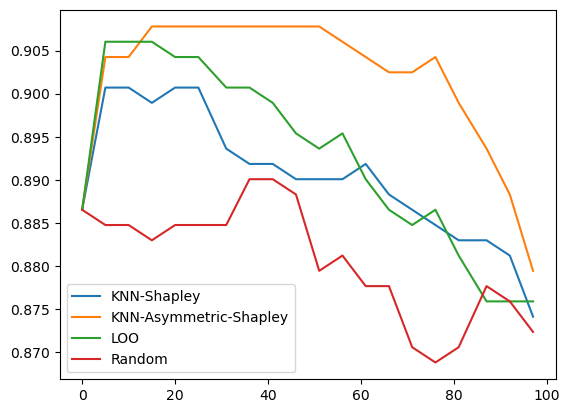

Removing high value sequential data experiment started...


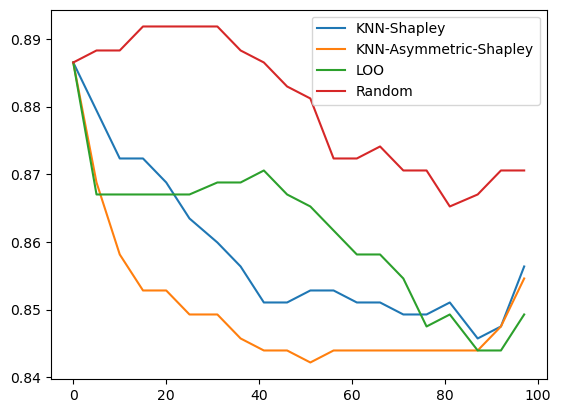

Adding low value sequential data experiment started...


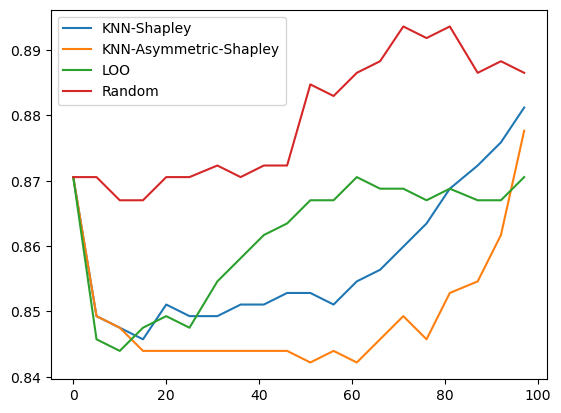

Adding high value sequential data experiment started...


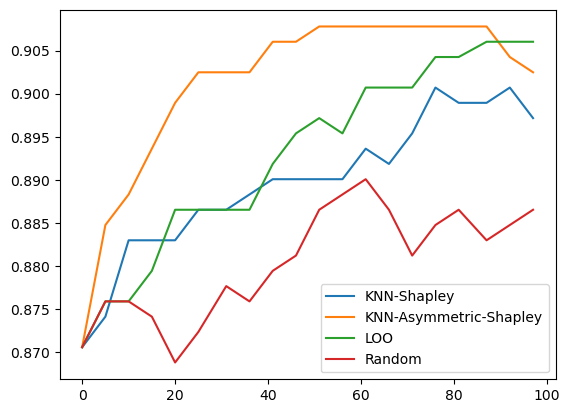

split 2
Removing low value sequential data experiment started...


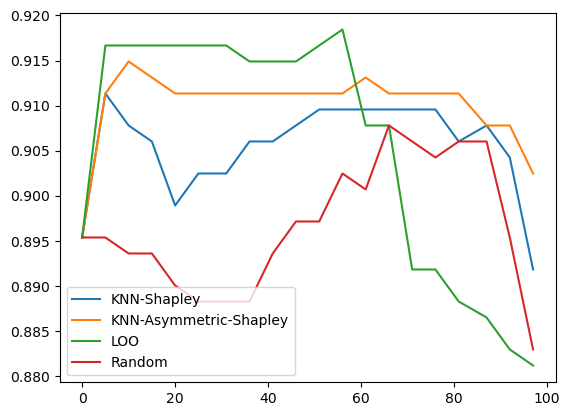

Removing high value sequential data experiment started...


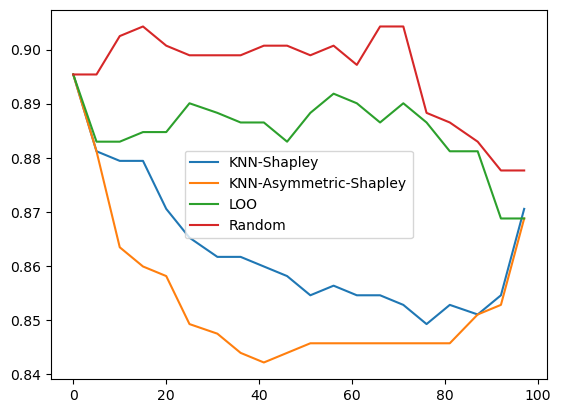

Adding low value sequential data experiment started...


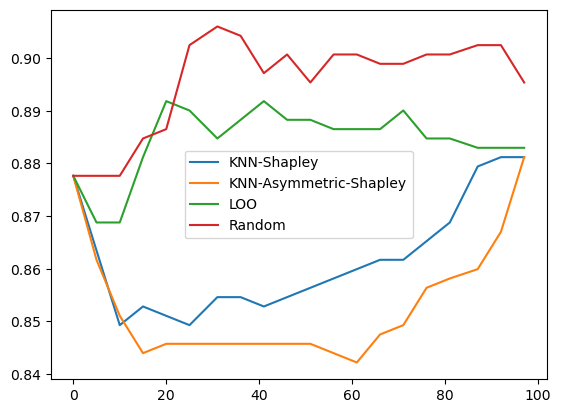

Adding high value sequential data experiment started...


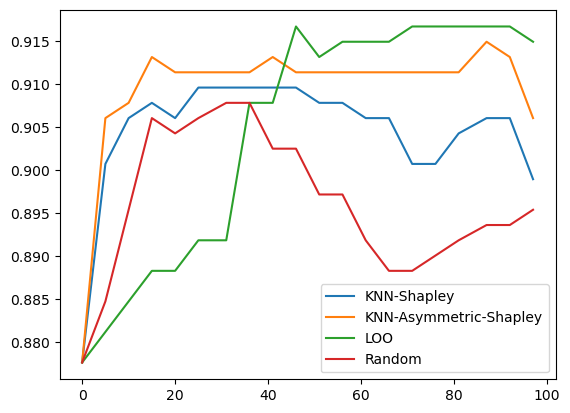

split 3
Removing low value sequential data experiment started...


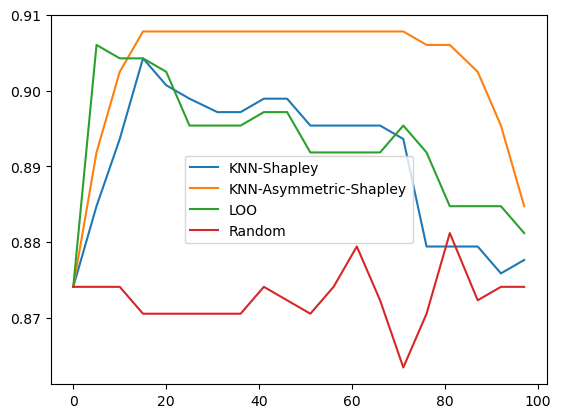

Removing high value sequential data experiment started...


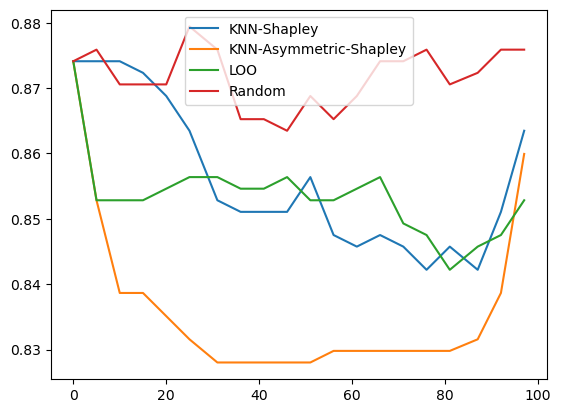

Adding low value sequential data experiment started...


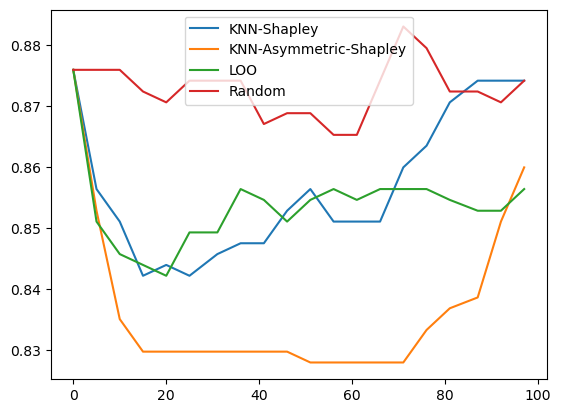

Adding high value sequential data experiment started...


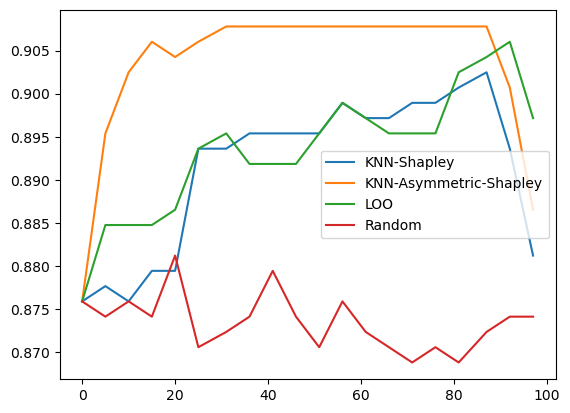

split 4
Removing low value sequential data experiment started...


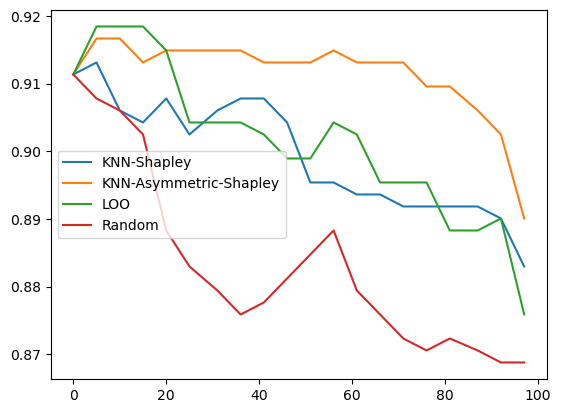

Removing high value sequential data experiment started...


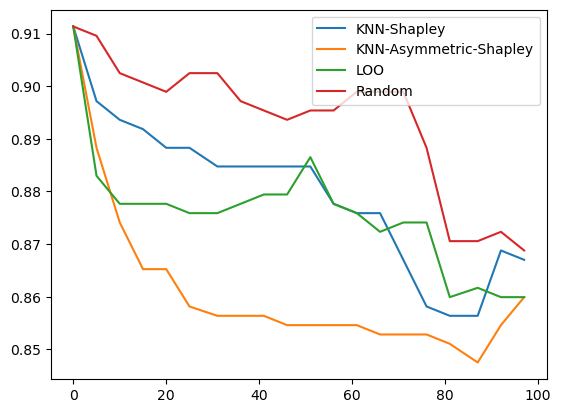

Adding low value sequential data experiment started...


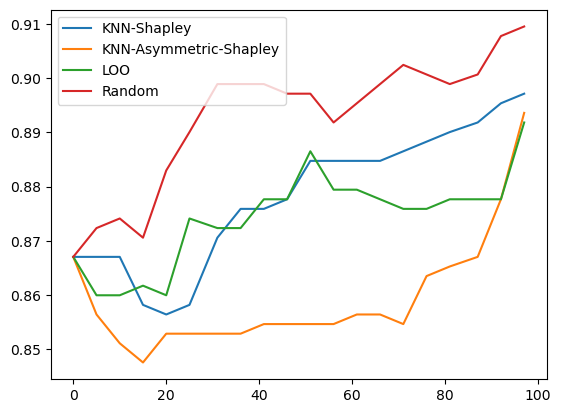

Adding high value sequential data experiment started...


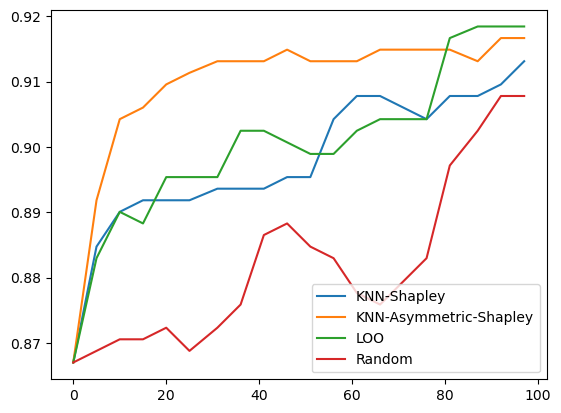

split 5
Removing low value sequential data experiment started...


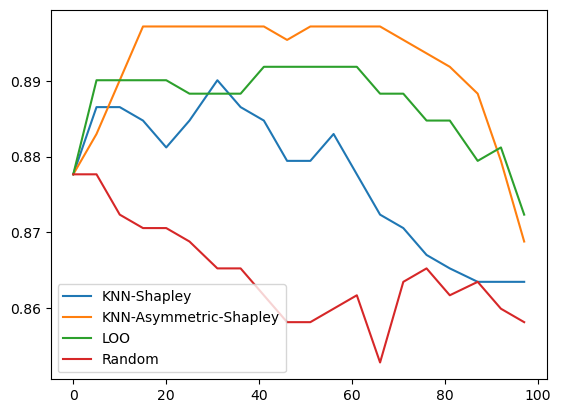

Removing high value sequential data experiment started...


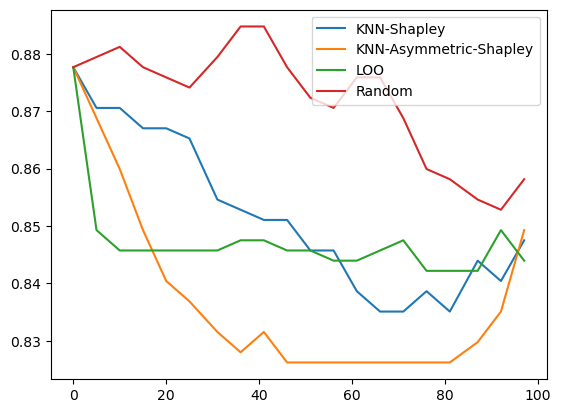

Adding low value sequential data experiment started...


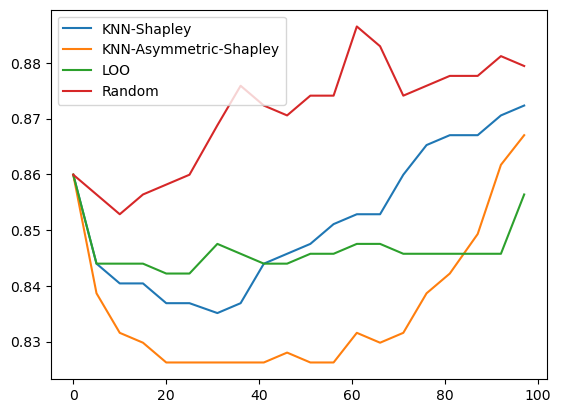

Adding high value sequential data experiment started...


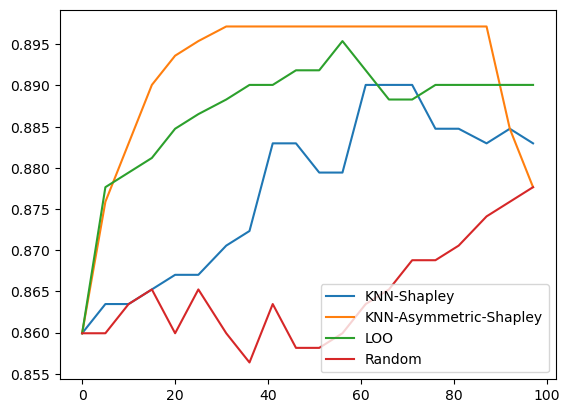

split 6
Removing low value sequential data experiment started...


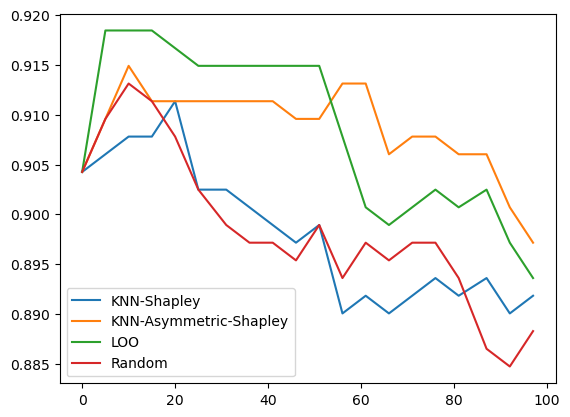

Removing high value sequential data experiment started...


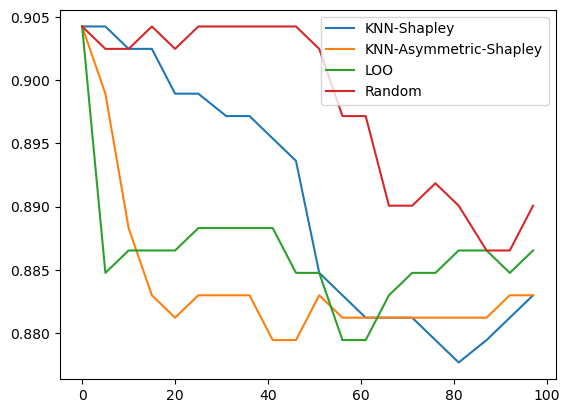

Adding low value sequential data experiment started...


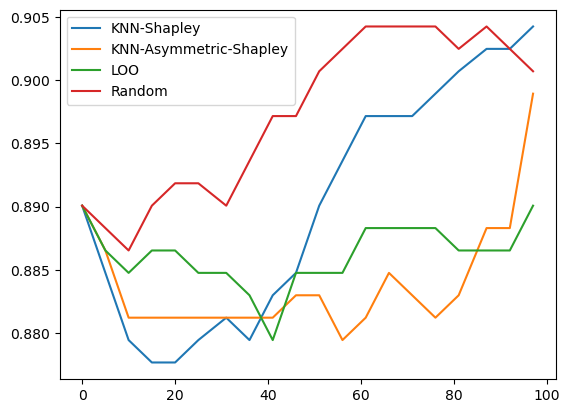

Adding high value sequential data experiment started...


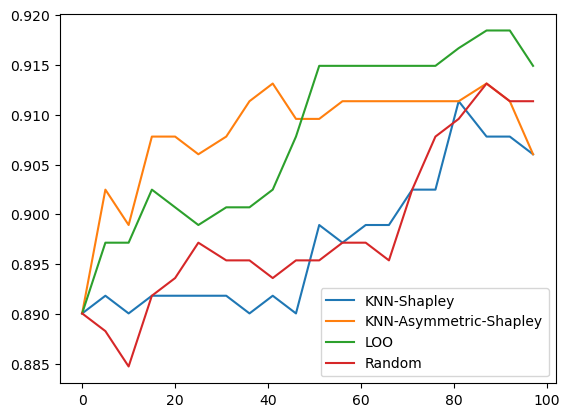

split 7
Removing low value sequential data experiment started...


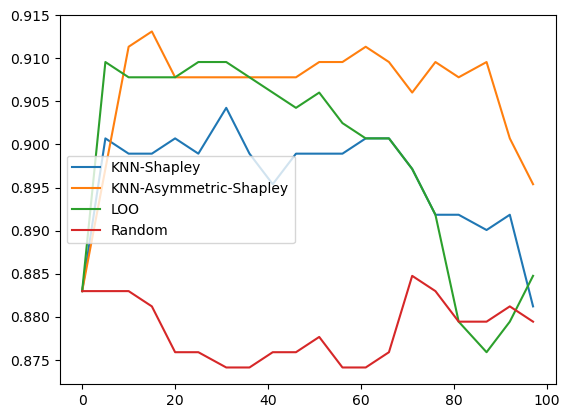

Removing high value sequential data experiment started...


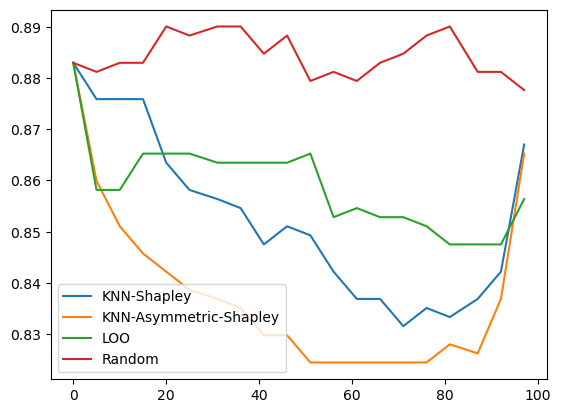

Adding low value sequential data experiment started...


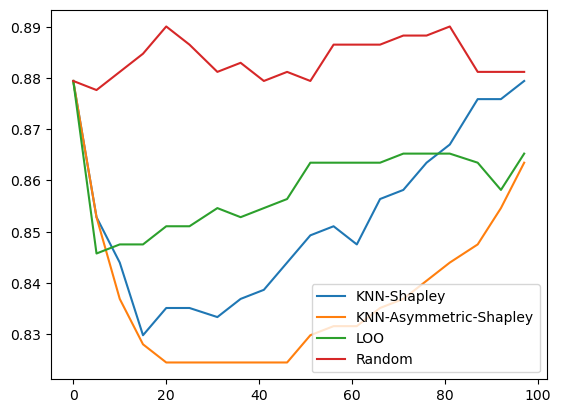

Adding high value sequential data experiment started...


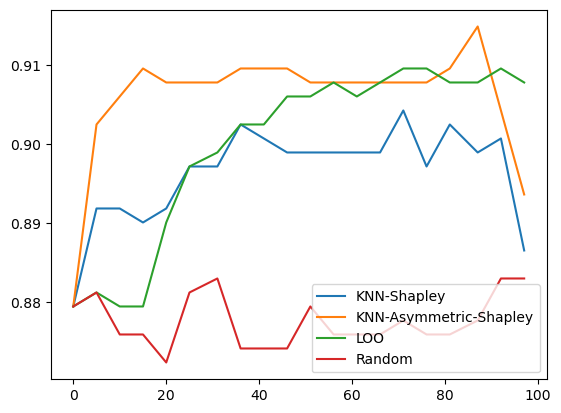

split 8
Removing low value sequential data experiment started...


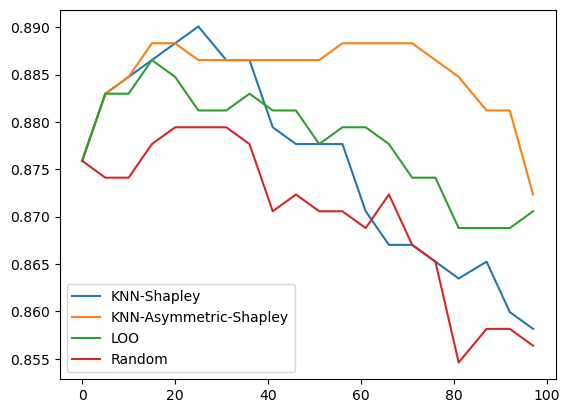

Removing high value sequential data experiment started...


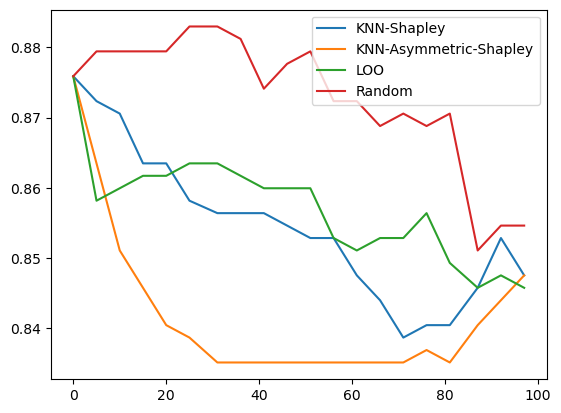

Adding low value sequential data experiment started...


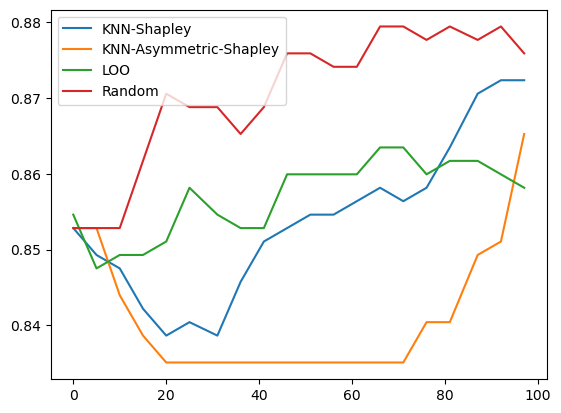

Adding high value sequential data experiment started...


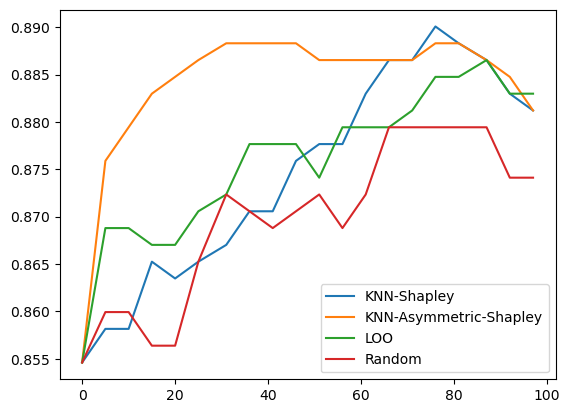

split 9
Removing low value sequential data experiment started...


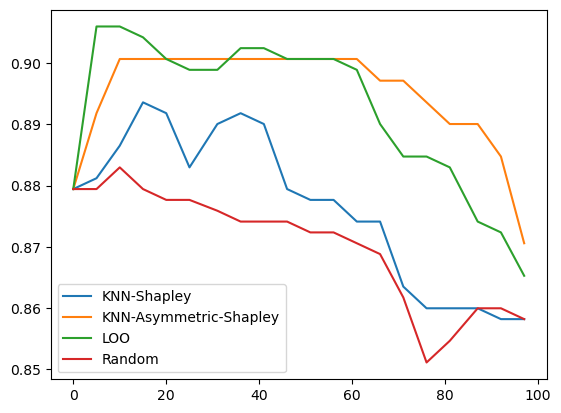

Removing high value sequential data experiment started...


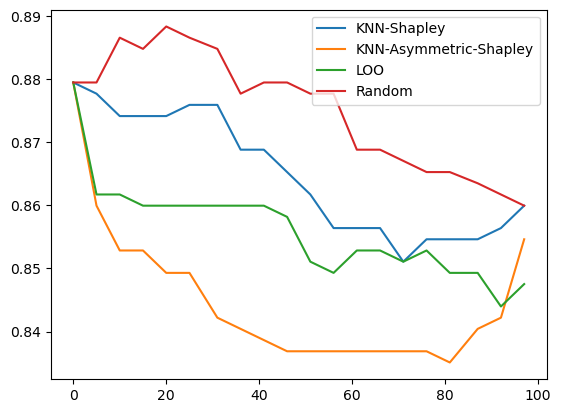

Adding low value sequential data experiment started...


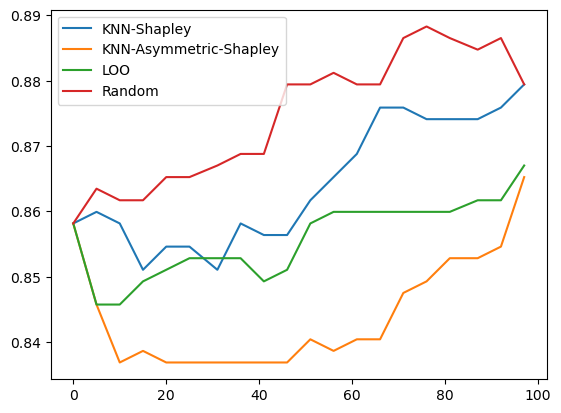

Adding high value sequential data experiment started...


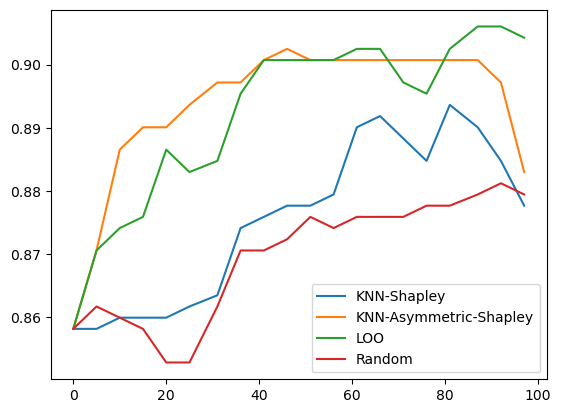

split 10
Removing low value sequential data experiment started...


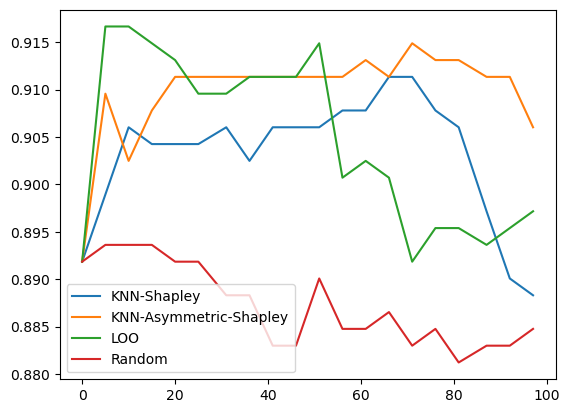

Removing high value sequential data experiment started...


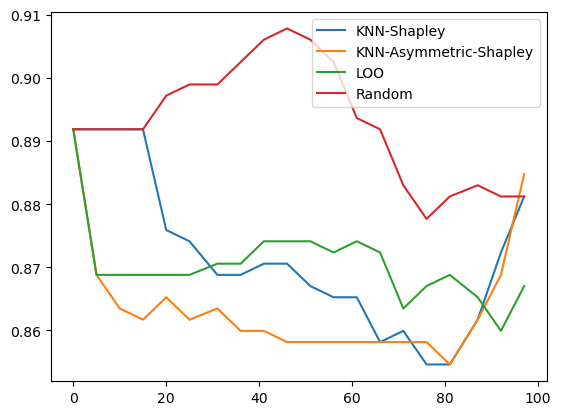

Adding low value sequential data experiment started...


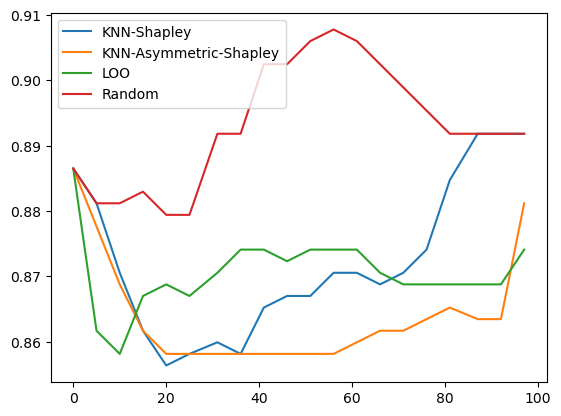

Adding high value sequential data experiment started...


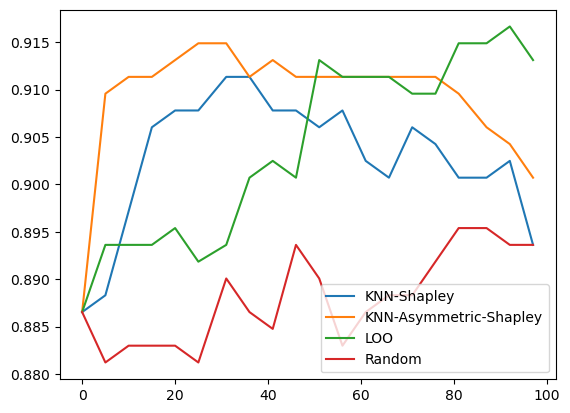

In [24]:
# Performance plot
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier as KNN
import matplotlib.pyplot as plt

K=5
model = KNN(n_neighbors=K, weights='uniform')
modelname='knn'

for i_split in range(n_samples):
    
    print('split', i_split+1)
    
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "rb") as fp:
        mydict = pickle.load(fp)
    
    X_m1m2_trn_selected = mydict['X_m1m2_trn_knn_selected']  
    y_m1m2_trn_selected = mydict['y_m1m2_trn_knn_selected'] 
    X_m1m2m3_trn_selected = mydict['X_m1m2m3_knn_selected']
    y_m1m2m3_trn_selected = mydict['y_m1m2m3_knn_selected']
    X_m1m2m3_val = mydict['X_{}_{}_{}_val'.format(m1, m2, m3)]
    y_m1m2m3_val = mydict['y_{}_{}_{}_val'.format(m1, m2, m3)]
    
    num_trn_ori2 = len(X_m1m2_trn_selected)
    ind_arr2 = np.zeros(X_m1m2m3_trn_selected.shape[0])
    ind_arr2[:X_m1m2_trn_selected.shape[0]] = 1

    directory2 = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_split+1)
    
    # Load KNN values
    m1m2m3_sv = np.load(directory2 + 'm1m2m3_sv_knn-asv-selected_experiment2_K={}.npy'.format(K))
    m1m2m3_asv = np.load(directory2 + 'm1m2m3_asv_knn-asv-selected_experiment2_K={}.npy'.format(K))
    m1m2m3_loo = np.load(directory2 + 'm1m2m3_loo_knn-asv-selected_experiment2_K={}.npy'.format(K))
    m1m2m3_rand = np.random.rand(len(m1m2m3_sv))
    
    shap_vals_lst = [m1m2m3_sv, m1m2m3_asv, m1m2m3_loo, m1m2m3_rand]
    shap_vals_algo_lst = ['KNN-Shapley', 'KNN-Asymmetric-Shapley', 'LOO', 'Random']
    
    remove_low_directory2 = directory2 + 'remove_low_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    remove_high_directory2 = directory2 + 'remove_high_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    add_low_directory2 = directory2 + 'add_low_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    add_high_directory2 = directory2 + 'add_high_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'

    print('Removing low value sequential data experiment started...')
    removing_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                             X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected,
                             X_test=X_m1m2m3_val, y_test=y_m1m2m3_val,
                             num_trn_ori=num_trn_ori2, ind_arr=ind_arr2, directory=remove_low_directory2,
                             plot_every_percentage = 0.05,
                             model=model, metrics='acc', low_value_first=True)

    print('Removing high value sequential data experiment started...')
    removing_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                             X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected,
                             X_test=X_m1m2m3_val, y_test=y_m1m2m3_val,
                             num_trn_ori=num_trn_ori2, ind_arr=ind_arr2, directory=remove_high_directory2,
                             plot_every_percentage = 0.05,
                             model=model, metrics='acc', low_value_first=False)

    print('Adding low value sequential data experiment started...')
    adding_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                           X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected,
                           X_test=X_m1m2m3_val, y_test=y_m1m2m3_val,
                           num_trn_ori=num_trn_ori2, ind_arr=ind_arr2, directory=add_low_directory2,
                           plot_every_percentage = 0.05,
                           model=model, metrics='acc', low_value_first=True)

    print('Adding high value sequential data experiment started...')
    adding_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                           X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected,
                           X_test=X_m1m2m3_val, y_test=y_m1m2m3_val,
                           num_trn_ori=num_trn_ori2, ind_arr=ind_arr2, directory=add_high_directory2,
                           plot_every_percentage = 0.05,
                           model=model, metrics='acc', low_value_first=False)

### 5. Final Plot (KNN model)

In [25]:
shap_vals_algo_lst = ['KNN-Shapley', 'KNN-Asymmetric-Shapley', 'LOO', 'Random']
remove_low_avg, remove_high_avg, add_low_avg, add_high_avg = {}, {}, {}, {}

for i_sample in range(n_samples):
    
    print('i_sample', i_sample+1)
    directory2 = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_sample+1)
    
    remove_low_directory2 = directory2 + 'remove_low_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    remove_high_directory2 = directory2 + 'remove_high_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    add_low_directory2 = directory2 + 'add_low_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'
    add_high_directory2 = directory2 + 'add_high_fig_data_model={}_algo_lst={}'.format(modelname, str(shap_vals_algo_lst)) + '.pickle'

    with open(remove_low_directory2, 'rb') as fp:
        remove_low = pickle.load(fp)
    
    with open(remove_high_directory2, 'rb') as fp:
        remove_high = pickle.load(fp)

    with open(add_low_directory2, 'rb') as fp:
        add_low = pickle.load(fp)

    with open(add_high_directory2, 'rb') as fp:
        add_high = pickle.load(fp)
    
    if i_sample == 0:
        for key in remove_low.keys():
            remove_low_avg[key] = [np.asarray(remove_low[key])]
            remove_high_avg[key] = [np.asarray(remove_high[key])]
    else:
        for key in remove_low.keys():
            remove_low_avg[key].append(np.asarray(remove_low[key]))
            remove_high_avg[key].append(np.asarray(remove_high[key]))
    
    if i_sample == 0:
        for key in add_low.keys():
            add_low_avg[key] = [np.asarray(add_low[key])]
            add_high_avg[key] = [np.asarray(add_high[key])]
    else:
        for key in add_low.keys():
            add_low_avg[key].append(np.asarray(add_low[key]))
            add_high_avg[key].append(np.asarray(add_high[key]))

            
for key in remove_high_avg.keys():
    if key == 'frac_data_removed':
        remove_high_avg[key] = remove_high_avg[key][0]
        remove_low_avg[key] = remove_low_avg[key][0]
    else:
        remove_high_avg[key] = np.vstack(remove_high_avg[key])
        remove_low_avg[key] = np.vstack(remove_low_avg[key])


for key in add_high_avg.keys():
    if key == 'frac_data_added':
        add_high_avg[key] = add_high_avg[key][0]
        add_low_avg[key] = add_low_avg[key][0]
    else:
        add_high_avg[key] = np.vstack(add_high_avg[key])
        add_low_avg[key] = np.vstack(add_low_avg[key])

i_sample 1
i_sample 2
i_sample 3
i_sample 4
i_sample 5
i_sample 6
i_sample 7
i_sample 8
i_sample 9
i_sample 10


In [28]:
def final_plot_avg(remove_high_avg, remove_low_avg, add_high_avg, add_low_avg, shap_algo_lst, dataset,
                   remove_add_ratio, xticks, root_dir, modelname, imbalance=False, experiment='ex1'):
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 2))
    dataset_font, title_font, label_font, ticks_font, legend_font = 15, 10, 8, 8, 6
    
    # Define the color map for the methods
    color_map = {
        'KNN-Shapley': 'purple',
        'KNN-Asymmetric-Shapley': 'orange',
        'MC-Shapley': 'blue',
        'MC-Asymmetric-Shapley': 'red',
        'LOO': 'green',
        'Random': 'grey'
    }

    # Define the line style for the methods
    line_style_map = {
        'KNN-Shapley': 'solid',
        'KNN-Asymmetric-Shapley':'solid',
        'MC-Shapley': 'solid',
        'MC-Asymmetric-Shapley': 'solid',
        'LOO':'solid',
        'Random': 'solid'
    }

    # Define the marker shapes for the methods
    marker_map = {
        'KNN-Shapley': '*',
        'KNN-Asymmetric-Shapley':'+',
        'MC-Shapley': 'o',  # Circle marker
        'MC-Asymmetric-Shapley': 's',  # Square marker
        'LOO': '^',  # Triangle marker
        'Random': 'd'  # Diamond marker
    }

    data_lst = [remove_low_avg, remove_high_avg, add_low_avg, add_high_avg]
    keys = ['frac_data_removed', 'frac_data_removed', 'frac_data_added', 'frac_data_added']

    # Define subtitles and x_labels
    if experiment == 'ex1':
        subtitles = ['Removing low value\nAugust data', 'Removing high value\nAugust data',
                     'Adding low value\nAugust data', 'Adding high value\nAugust data']
        x_labels = ['Fraction of August data removed (%)', 'Fraction of August data removed (%)',
                    'Fraction of August data added (%)', 'Fraction of August data added (%)']
    else:
        subtitles = ['Removing low value\nSeptember data', 'Removing high value\nSeptember data',
                     'Adding low value\nSeptember data', 'Adding high value\nSeptember data']
        x_labels = ['Fraction of September data removed (%)', 'Fraction of September data removed (%)',
                    'Fraction of September data added (%)', 'Fraction of September data added (%)']

    for i in range(len(data_lst)):
        ymin, ymax = 1, 0
        for j in range(len(shap_algo_lst)):
            bool_ratio = (np.array(data_lst[i][keys[i]]) <= remove_add_ratio)
            
            results = data_lst[i][shap_algo_lst[j]]
            normalized_results = data_lst[i][shap_algo_lst[j]] / data_lst[i][shap_algo_lst[j]][:, [0]]
            # Calculate the mean across the n repetitions
            mean_rslts = np.mean(normalized_results, axis=0)     
            # Calculate the 90% confidence interval
            confidence_band = 1.645 * np.std(normalized_results, axis=0) / np.sqrt(normalized_results.shape[0])
            
            # Plotting the mean and confidence band with markers
            axes[i].plot(
                data_lst[i][keys[i]][bool_ratio], 
                mean_rslts[bool_ratio], 
                color=color_map[shap_algo_lst[j]], 
                linestyle=line_style_map[shap_algo_lst[j]], 
                marker=marker_map[shap_algo_lst[j]],  # Apply marker for each algorithm
                lw=2, markersize=4
            )
            axes[i].fill_between(
                data_lst[i][keys[i]][bool_ratio],
                mean_rslts[bool_ratio] - confidence_band[bool_ratio], 
                mean_rslts[bool_ratio] + confidence_band[bool_ratio], 
                color=color_map[shap_algo_lst[j]], 
                alpha=0.1, 
                label="90% Confidence Band"
            )
            if min(mean_rslts[bool_ratio] - confidence_band[bool_ratio]) < ymin:
                ymin = min(mean_rslts[bool_ratio] - confidence_band[bool_ratio])
            if max(mean_rslts[bool_ratio] + confidence_band[bool_ratio]) > ymax:
                ymax = max(mean_rslts[bool_ratio] + confidence_band[bool_ratio])
            
        # Set x-ticks
        axes[i].set_xticks(xticks)
        
        # Set y-lim
        if i == 0:
            axes[i].set_ylim((ymin-0.03, ymax+0.01))
        else:
            axes[i].set_ylim((ymin-0.01, ymax+0.01))
            
        # Set titles with bold font and in two lines
        axes[i].set_title(subtitles[i], fontsize=title_font, fontweight='bold')
        axes[i].set_xlabel(x_labels[i], fontsize=label_font)

        # Set the y-label and add the dataset name to the first plot
        if imbalance:
            axes[i].set_ylabel('Relative AUC (%)', fontsize=label_font)
        else:
            axes[i].set_ylabel('Relative accuracy (%)', fontsize=label_font)

        # Add the dataset name to the left side of the first plot
        if i == 0:
            axes[i].text(-0.5, 0.8, dataset, fontsize=dataset_font,
                         fontweight='bold', 
                         va='top', ha='center', rotation=90,
                         transform=axes[i].transAxes)

    # Adjust the spacing between plots to make more room for y-labels
    plt.subplots_adjust(left=0.1, right=0.85, wspace=0.5)  # Increase wspace for more room between plots

    # Create custom colorbar based on the defined color map
    from matplotlib.colors import ListedColormap
    import matplotlib as mpl

    # Convert the color map values into a colormap object
    cmap = ListedColormap([color_map[algo] for algo in shap_algo_lst])

    # Normalize the ticks for the colorbar
    norm = mpl.colors.BoundaryNorm(boundaries=np.arange(len(shap_algo_lst)+1)-0.5, ncolors=len(shap_algo_lst))

    # Create the colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    colorbar = plt.colorbar(sm, ax=axes, orientation='vertical', pad=0.02, fraction=0.05)
    colorbar.set_ticks(np.arange(len(shap_algo_lst)))
    colorbar.set_ticklabels(shap_algo_lst)
    
    # Save the figure with bbox_inches to avoid cutting off the titles
    plt.savefig(root_dir + 'final_plot_model={}.jpg'.format(modelname), dpi=500, 
                bbox_inches='tight')
    plt.show()
    return

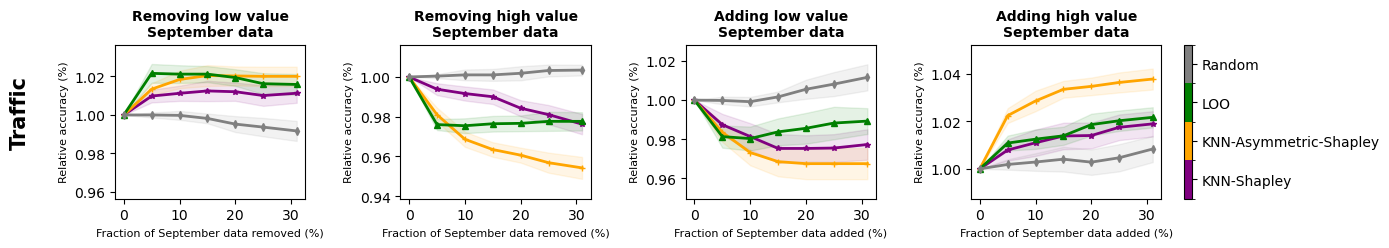

In [30]:
# Plot final plot

final_plot_avg(remove_high_avg, remove_low_avg, add_high_avg, 
               add_low_avg, shap_vals_algo_lst, remove_add_ratio = 35,
               xticks=[0, 10, 20, 30], modelname='knn',
               root_dir='experiments/sequential data valuation/traffic 10 random splits/experiment_1/validation data/',
               experiment='ex2',
               dataset='Traffic', imbalance=False)